<h1><center> MATH 472/572 Computational Statistics - Spring 2020 </h1></center>
<h2><center> Homework 9 - Due April 7, Tuesday </h2></center>
<h3><center> Instructor: Leming Qu </h3></center>

<h1><center> Student: Arash Modaresi Rad </h1></center>

## Coding Assignments:

In [1]:
import numpy as np
import seaborn as sb
import sympy as sym
from sympy import *
from numpy import ma
from numpy.linalg import inv
from numpy import linalg as LA
import pandas as pd 
import matplotlib.pyplot as plt  
import functools as fts
from tabulate import tabulate as tabulate
from scipy.stats import norm, uniform, lognorm, gamma, poisson
from scipy import stats
from scipy import integrate

np.random.seed(1100)

**1. (20 Points) Problem 6.7 on page 198 of Computational Statistics.
Required output: print appropriate numbers, texts, visual displays to the Jupyter notebook
to show the results for each question.**

a. Confirm that the fair price for this option is 2.10 when the payoff is based on S(30)
[i.e., a standard option with payoff as in (6.74)].

In [2]:
# S = prices of stock over time
# S0 = price at time zero
# ST = price at time T
# K = strike price
# T = time of maturity
# r = risk-free rate of return
# n = number of iterations
# m = number of mc estimations
# sigma = stock's volatility
#########################################################################

S0 = 50
K = 52
sigma = 0.5
T = 30
r = 0.05
n = 10000
m = 100

In [3]:
Mu_MC = np.zeros(m)
for i in range (m):
    ST=S0*np.exp((r-(sigma**2)/2)*T/365 + sigma*np.random.normal(0, 1, n)*np.sqrt(T/365))
    C = np.exp(-r*T/365)*np.maximum(np.zeros(n),(ST - K))
    Mu_MC[i] = np.mean(C)
std_Mu_MC = np.std(Mu_MC)/np.sqrt(m)

In [4]:
print("standard Monte Carlo estimate of the fair price for European call option : {}".format(np.mean(Mu_MC)))
print("standard Monte Carlo standard deviation of the fair price for European call option: {}".format(std_Mu_MC))

standard Monte Carlo estimate of the fair price for European call option : 2.110153402194426
standard Monte Carlo standard deviation of the fair price for European call option: 0.004053389157258097


b. Consider the analogous Asian option (same S(0), K, σ, N, and r) with payoff based
on the arithmetic mean stock price during the holding period, as in (6.77). Using
simple Monte Carlo, estimate the fair price for this option.

In [5]:
def asian(S_0,K,sigma,T,r):
    n = 1000
    m = 100
    mu_mc = []
    theta_mc = []
    for i in range(0,m):
        a_mc = []
        theta = []
        for j in range (0,n):
            S_t = []
            S_t.append(S_0)
            log_st = []
            log_st.append(np.log(S_t[0]))   
            for k in range(1,T+1):
                S_t.append(S_t[k-1]*np.exp((r-sigma**2/2)/365 + sigma*norm.rvs(size=1)/np.sqrt(365)))
                log_st.append(np.log(S_t[k]))
            a_mc.append(np.exp(-r*T/365)*max(0,np.asscalar(np.mean(S_t[1:k])-K)))
            theta.append(np.exp(-r*T/365)*max(0,np.asscalar(np.exp(np.mean(log_st[1:k])) - K)))
        mu_mc.append(np.mean(a_mc))
        theta_mc.append(np.mean(theta))
    return mu_mc,theta_mc

In [6]:
T=30
n = 1000
m = 100
X = np.random.normal(0, 1, (m, n, T))

In [7]:
def Func(m, n):
    Y = np.exp(((r-(sigma**2)/2)/365)+sigma*X/np.sqrt(365))
    return Y

def MC(m, n):
    Mu_MC = []
    Theta_MC = []
    for i in range(0, m):
        A = []
        Theta = []
        for j in range (0, n):
            ST = []
            ST.append(S0)
            for k in range(1,T+1):
                temp = ST[k-1]*np.exp((r-sigma**2/2)/365 + sigma*norm.rvs(size=1)/np.sqrt(365))
                ST.append(temp) 
            temp = np.exp(-r*T/365)*max(0,np.asscalar(np.mean(ST[1:k])-K)) 
            A.append(temp)
            temp = np.exp(-r*T/365)*max(0,np.asscalar(np.exp(np.mean(np.log(ST[1:k])))- K))
            Theta.append(temp) 
        Mu_MC.append(np.mean(A))
        Theta_MC.append(np.mean(Theta))
    return Mu_MC, Theta_MC 

In [8]:
Mu_MC, Theta_MC = MC(m, n)
print("standard Monte Carlo estimate : {}".format(np.mean(Mu_MC)))
print("standard Monte Carlo standard deviation: {}".format(std_Mu_MC))

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


standard Monte Carlo estimate : 0.9193437794743923
standard Monte Carlo standard deviation: 0.004053389157258097


c. Improve upon the estimate in (b) using the control variate strategy described in
Example 6.13

In [9]:
N = T
c3 = 1 + 1/N
c2 = sigma*((c3*T/1095)*(1 + 1/(2*N)))**0.5
c1 = (1/c2)*(np.log(S0/K) + (c3*T/730)*(r - (sigma**2)/2)+(c3*(sigma**2)*T/1095)*(1 + 1/(2*N)))
Theta = S0*norm.cdf(c1)*np.exp(-T*(r + c3*(sigma**2)/6)*(1 - 1/N)/730)-K*norm.cdf(c1-c2)*np.exp(-r*T/365)

Implement Control Variate:

In [10]:
Par = -np.cov(Mu_MC, Theta_MC)[0,1] / np.var(Theta_MC)
Mu_CV = Mu_MC + Par * (Theta_MC - Theta)

print("Control Variate estimate : {}".format(np.mean(Mu_CV)))
print("Control Variate standard deviation: {}".format(np.std(Mu_CV)))

Control Variate estimate : 0.944160334406132
Control Variate standard deviation: 0.001461068934444281


d. Try an antithetic approach to estimate the fair price for the option described in
part (b).

In [25]:
def MC_AS(m, n, X):
    Mu_MC = []
    Theta_MC = []
    for i in range(0, m):
        A = []
        Theta = []
        for j in range (0, np.int(n/2)):
            ST = []
            ST.append(S0)
            for k in range(1,T+1):
                temp = ST[k-1]*np.exp((r-sigma**2/2)/365 + sigma*X[i,j,k-1]/np.sqrt(365))
                ST.append(temp) 
            temp = np.exp(-r*T/365)*max(0,np.asscalar(np.mean(ST[2:k])-K)) 
            A.append(temp)
            temp = np.exp(-r*T/365)*max(0,np.asscalar(np.exp(np.mean(np.log(ST[2:k])))- K))
            Theta.append(temp) 
        Mu_MC.append(np.mean(A))
        Theta_MC.append(np.mean(Theta))
    return Mu_MC, Theta_MC 

In [26]:
X = np.random.normal(0, 1,(m, n, T))[:, 0:np.int(n/2), :]
h_1 = MC_AS(m, n, X)[0] 
h_2 = MC_AS(m, n, -X)[0] 
Mu_AS_e = (np.mean(h_1) + np.mean(h_2)) / 2

C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  del sys.path[0]
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  from ipykernel import kernelapp as app


In [13]:
Mu_AS_d = np.concatenate((h_1,h_2))

In [14]:
print("Antithetic Sampling estimate : {}".format(np.mean(Mu_AS_d)))
print("Antithetic Sampling standard deviation: {}".format(np.std(Mu_AS_d)))

Antithetic Sampling estimate : 0.9249547381324854
Antithetic Sampling standard deviation: 0.08881879701185874


e. Using simulation and/or analysis, compare the sampling distributions of the estimators in (b), (c), and (d).

In [24]:
print("standard Monte Carlo estimate : {}".format(np.mean(Mu_MC[])))
print("standard Monte Carlo standard deviation: {}".format(np.std(Mu_MC)))
print("\n________________________________________________________________\n")
print("Control Variate estimate : {}".format(np.mean(Mu_CV)))
print("Control Variate standard deviation: {}".format(np.std(Mu_CV)))
print("\n________________________________________________________________\n")
print("Antithetic Sampling estimate : {}".format(np.mean(Mu_AS_d)))
print("Antithetic Sampling standard deviation: {}".format(np.std(Mu_AS_d)))

standard Monte Carlo estimate : 0.9190054372730311
standard Monte Carlo standard deviation: 0.05926186701882028

________________________________________________________________

Control Variate estimate : 0.944160334406132
Control Variate standard deviation: 0.001461068934444281

________________________________________________________________

Antithetic Sampling estimate : 0.9249547381324854
Antithetic Sampling standard deviation: 0.08881879701185874


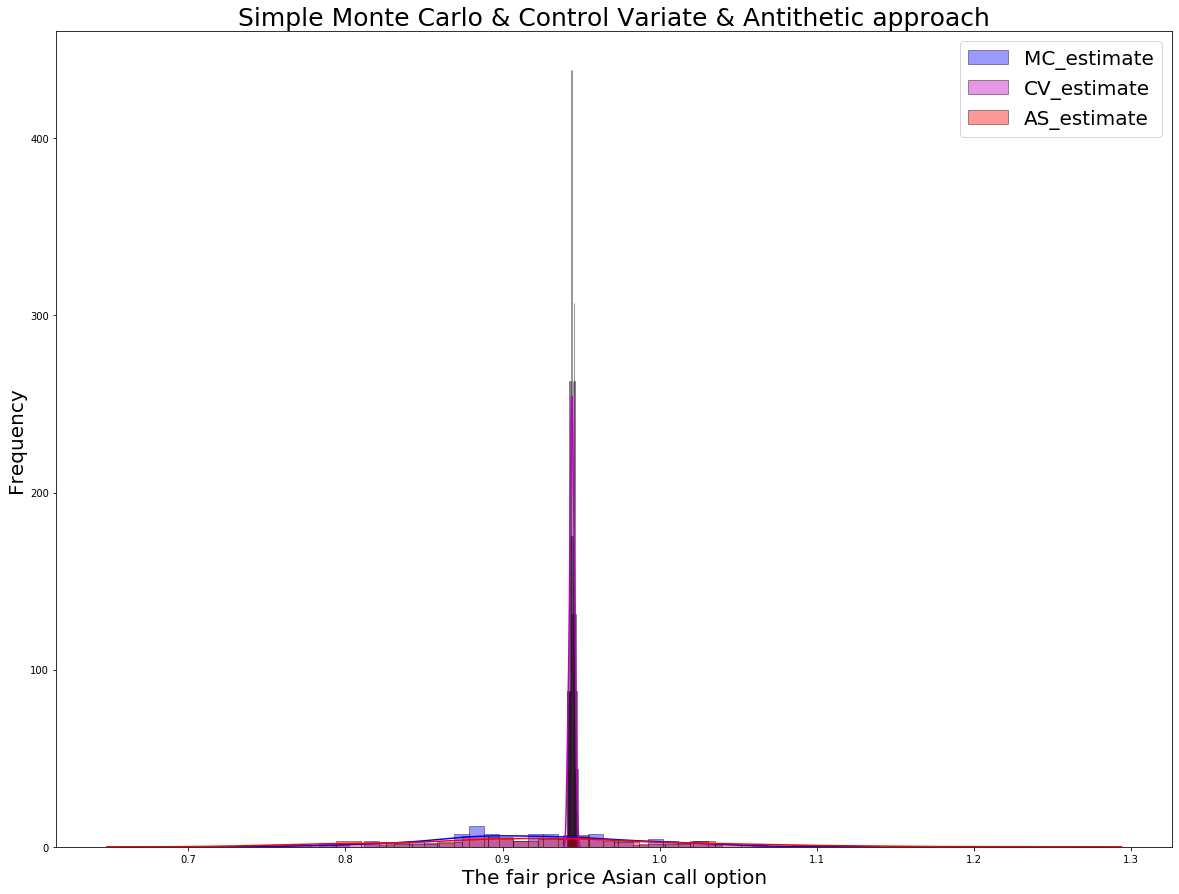

In [16]:
plt.figure(figsize=(20,15))
sb.distplot(Mu_MC, hist=True, kde=True, bins=30, color='b',
           hist_kws={'edgecolor':'black',"label": "MC_estimate"},
           norm_hist=True,
           axlabel=r'$x$')
sb.distplot(Mu_CV, hist=True, kde=True, bins=30,  color='m',
           hist_kws={'edgecolor':'black',"label": "CV_estimate"},
           norm_hist=True,
           axlabel=r'$x$')
sb.distplot(Mu_AS_d, hist=True, kde=True, bins=30,  color='r',
           hist_kws={'edgecolor':'black',"label": "AS_estimate"},
           norm_hist=True,
           axlabel=r'$x$')
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('The fair price Asian call option',fontsize=20)
plt.title('Simple Monte Carlo & Control Variate & Antithetic approach',fontsize=25)
plt.legend(fontsize = 20)
plt.show()

plotting them seperately:

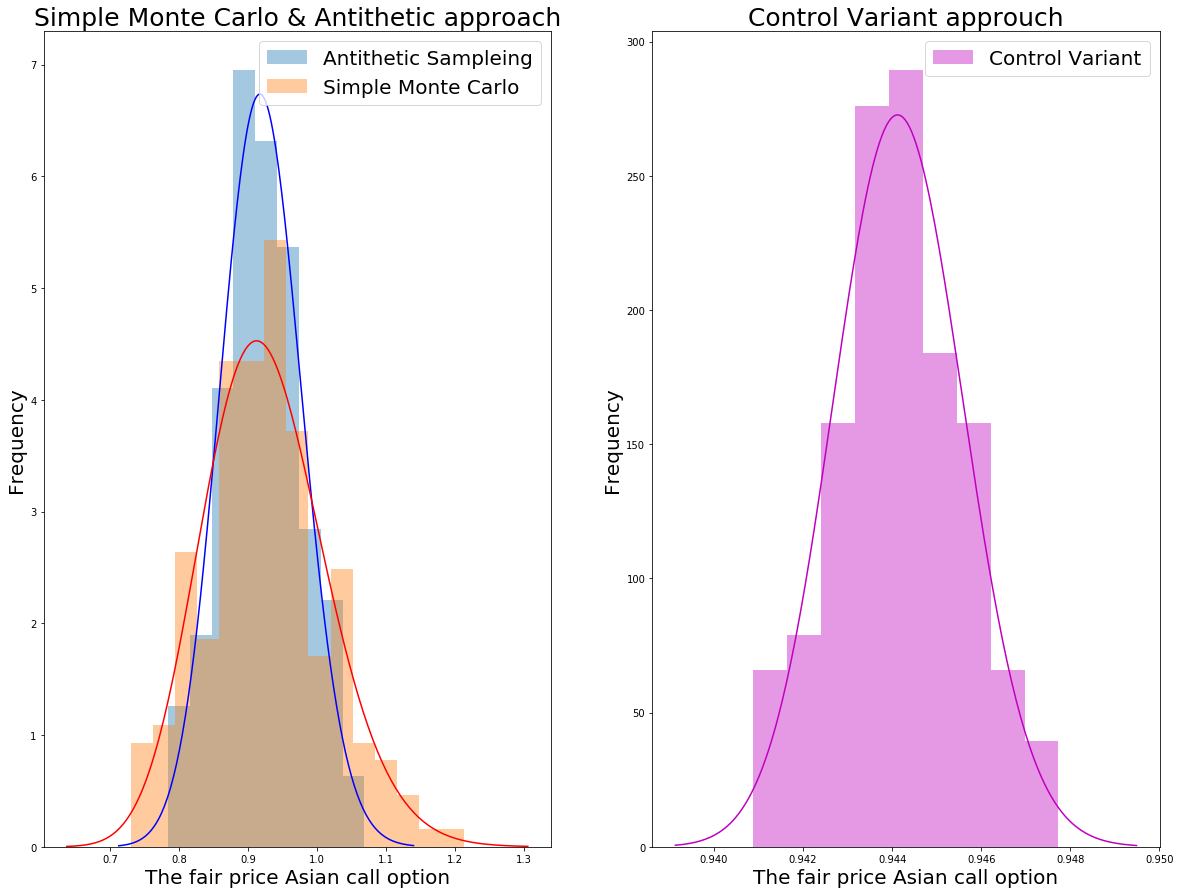

In [17]:
plt.figure(figsize=(20,15))
plt.subplot(1, 2, 1)
ax = sb.distplot(Mu_MC, fit_kws={"color":"b"},  kde=False, fit=stats.gamma, hist=True, label="Antithetic Sampleing");
ax = sb.distplot(Mu_AS_d, fit_kws={"color":"r"}, kde=False, fit=stats.gamma, hist=True, label="Simple Monte Carlo");
plt.xlabel('The fair price Asian call option',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title('Simple Monte Carlo & Antithetic approach',fontsize=25)
plt.legend(fontsize = 20)
plt.subplot(1, 2, 2)

ax = sb.distplot(Mu_CV, fit_kws={"color":"m"}, kde=False, fit=stats.gamma, hist=True,  color='m', label="Control Variant");
plt.xlabel('The fair price Asian call option',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend(fontsize = 20)
plt.title('Control Variant approuch',fontsize=25)
plt.show()

**2. (20 Points) Problem 6.8 on page 198 of Computational Statistics.
Required output: print appropriate numbers, texts, visual displays to the Jupyter notebook
to show the results**

Setup the problem:

In [18]:
n = 10000
simulations = 100
eps = np.random.normal(0, 1, n)

In [19]:
def Func(x): 
    Y = np.exp(9 + 3 * np.log(x) + eps) 
    return Y

Setup Monte Carlo & Rao–Blackwellized:

In [20]:
Mu_MC2 = np.zeros((simulations, 1))
Mu_RB = np.zeros((simulations, 1))
eps = norm.rvs(size=n)
for i in range (simulations):
    X = np.random.lognormal(0, 1, n)
    Mu_MC2[i] = np.mean(Func(X) / X)
    Mu_RB[i] = np.mean(np.exp(9) * (X ** 2) * np.exp(1/2))

print("standard Monte Carlo estimate : {}".format(np.mean(Mu_MC2)))
print("standard Monte Carlo standard deviation: {}".format(np.std(Mu_MC2)))
print("\n________________________________________________________________\n")
print("Rao–Blackwellized estimate : {}".format(np.mean(Mu_RB)))
print("Rao–Blackwellized standard deviation: {}".format(np.std(Mu_RB)))

standard Monte Carlo estimate : 96771.6312084033
standard Monte Carlo standard deviation: 7309.27242326326

________________________________________________________________

Rao–Blackwellized estimate : 98652.11495771538
Rao–Blackwellized standard deviation: 5778.938337329165


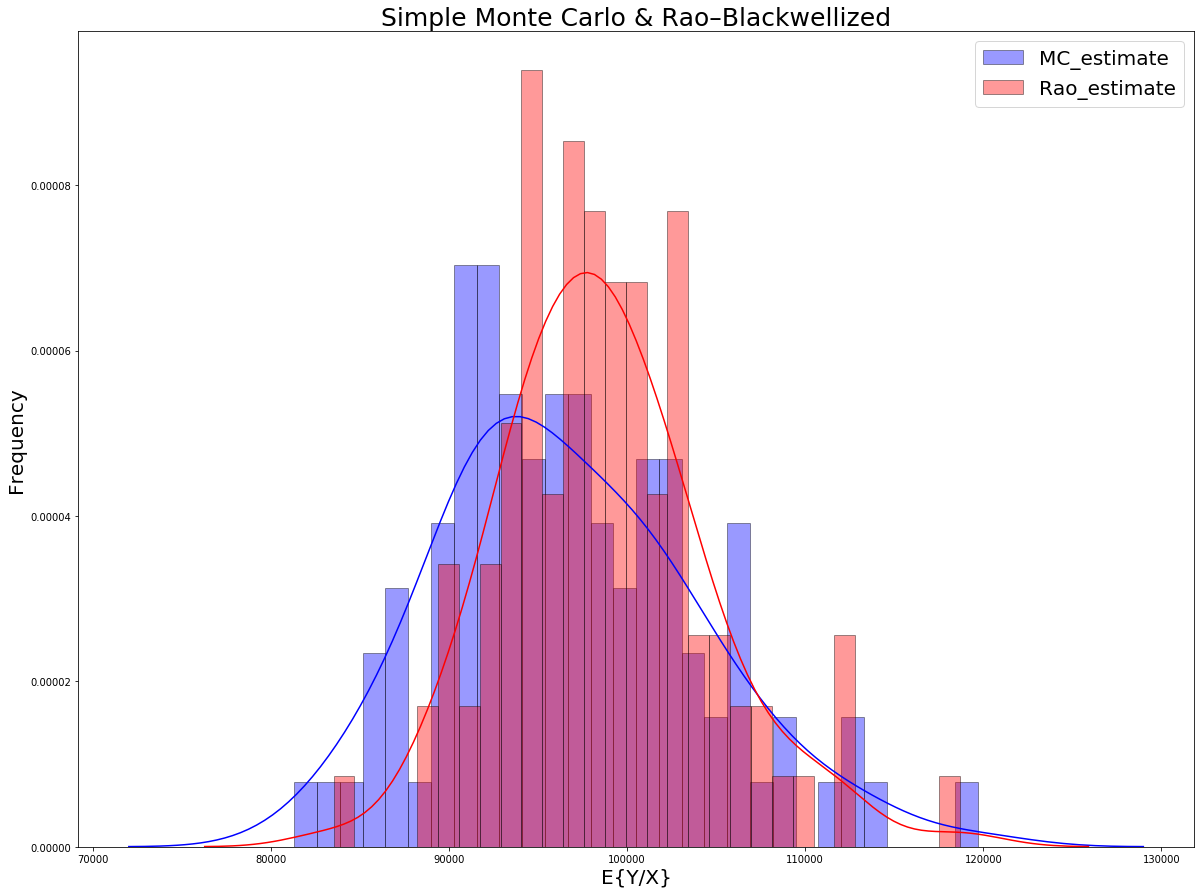

In [21]:
plt.figure(figsize=(20,15))
sb.distplot(Mu_MC2, hist=True, kde=True, bins=30, color='b',
           hist_kws={'edgecolor':'black',"label": "MC_estimate"},
           norm_hist=True,
           axlabel=r'$x$')

sb.distplot(Mu_RB, hist=True, kde=True, bins=30,  color='r',
           hist_kws={'edgecolor':'black',"label": "Rao_estimate"},
           norm_hist=True,
           axlabel=r'$x$')
plt.ylabel('Frequency',fontsize=20)
plt.xlabel('E{Y/X}',fontsize=20)
plt.title('Simple Monte Carlo & Rao–Blackwellized',fontsize=25)
plt.legend(fontsize = 20)
plt.show()